# sklearn example of SVM model and RandomForest and SVM attack with AUC and histograms

This notebook gives an example of performing MIA using sklearn models. It makes the following MIA assumptions:
1. Attacker has access to the exact train and test data. Unrealistic, but maybe worst case.
1. Attacker builds a target model based on the predictive probabilities of the classifier on the train and test data.

This is the scenario we have been discussing, which is neither Shokri or Salem, but might be useful given it is somewhat assumption-free.

Download data from https://physionet.org/content/mimic2-iaccd/1.0/ (https://physionet.org/content/mimic2-iaccd/1.0/full_cohort_data.csv to download the full_cohort data)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
import itertools

%matplotlib inline

In [3]:
path = "../../data/mimic2-iaccd/1.0/"

In [4]:
data_path = os.path.join(path, 'full_cohort_data.csv')

In [5]:
X = pd.read_csv(data_path)

In [6]:
X.shape

(1776, 46)

## Explore the data

In [7]:
X.head()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_unit,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
0,1,7.63,13,72.36841,1.0,75.0,29.912791,15.0,9.0,SICU,...,354.0,138.0,4.6,15.0,109.0,41.0,1.6,196.0,39.0,2230.875000
1,0,1.14,1,64.92076,0.0,55.0,20.121312,NaN,5.0,MICU,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,600.000000
2,0,2.86,5,36.50000,0.0,70.0,27.118272,16.0,5.0,MICU,...,295.0,144.0,3.9,17.0,101.0,16.0,0.8,298.0,30.0,2086.800293
3,1,0.58,3,44.49191,0.0,NaN,NaN,21.0,7.0,SICU,...,262.0,139.0,4.2,31.0,100.0,16.0,0.5,146.0,23.0,NaN
4,1,1.75,5,23.74217,1.0,95.2,28.464563,18.0,7.0,SICU,...,22.0,146.0,3.4,19.0,110.0,10.0,1.0,134.0,30.0,2358.244141


In [8]:
X.describe()

,aline_flg,icu_los_day,hospital_los_day,age,gender_num,weight_first,bmi,sapsi_first,sofa_first,service_num,...,platelet_first,sodium_first,potassium_first,tco2_first,chloride_first,bun_first,creatinine_first,po2_first,pco2_first,iv_day_1
count,1776.000000,1776.000000,1776.000000,1776.000000,1775.000000,1666.000000,1310.000000,1691.000000,1770.000000,1776.000000,...,1768.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1770.000000,1590.000000,1590.000000,1633.000000
mean,0.554054,3.346498,8.110923,54.379660,0.577465,80.075948,27.827316,14.136606,5.820904,0.552928,...,246.083145,139.559006,4.107623,24.416657,103.839074,19.277809,1.095706,227.623270,43.413836,1622.907946
std,0.497210,3.356261,8.157159,21.062854,0.494102,22.490516,8.210074,4.114302,2.334666,0.497331,...,99.865469,4.726209,0.794724,4.992172,5.734283,14.366890,1.083477,144.863403,13.980786,1677.129157
min,0.000000,0.500000,1.000000,15.180230,0.000000,30.000000,12.784877,3.000000,0.000000,0.000000,...,7.000000,105.000000,1.900000,2.000000,78.000000,2.000000,0.000000,22.000000,8.000000,0.000000
25%,0.000000,1.370000,3.000000,38.247318,0.000000,65.400000,22.617307,11.000000,4.000000,0.000000,...,182.000000,137.000000,3.600000,22.000000,101.000000,11.000000,0.700000,108.000000,36.000000,329.750000
50%,1.000000,2.185000,6.000000,53.678585,1.000000,77.000000,26.324846,14.000000,6.000000,1.000000,...,239.000000,140.000000,4.000000,24.000000,104.000000,15.000000,0.900000,195.000000,41.000000,1081.529175
75%,1.000000,4.002500,10.000000,72.762992,1.000000,90.000000,30.796551,17.000000,7.000000,1.000000,...,297.000000,142.000000,4.400000,27.000000,107.000000,22.000000,1.100000,323.000000,47.000000,2493.900146
max,1.000000,28.240000,112.000000,99.110950,1.000000,257.600000,98.797134,32.000000,17.000000,1.000000,...,988.000000,165.000000,9.800000,62.000000,133.000000,139.000000,18.300000,634.000000,158.000000,13910.000000


Identify the number of NaNs in each column, and remove columns with a lot of them

In [9]:
for col in X.columns:
    print(col, X[col].isnull().sum().sum())

aline_flg 0
icu_los_day 0
hospital_los_day 0
age 0
gender_num 1
weight_first 110
bmi 466
sapsi_first 85
sofa_first 6
service_unit 0
service_num 0
day_icu_intime 0
day_icu_intime_num 0
hour_icu_intime 0
hosp_exp_flg 0
icu_exp_flg 0
day_28_flg 0
mort_day_censored 0
censor_flg 0
sepsis_flg 0
chf_flg 0
afib_flg 0
renal_flg 0
liver_flg 0
copd_flg 0
cad_flg 0
stroke_flg 0
mal_flg 0
resp_flg 0
map_1st 0
hr_1st 0
temp_1st 3
spo2_1st 0
abg_count 0
wbc_first 8
hgb_first 8
platelet_first 8
sodium_first 5
potassium_first 5
tco2_first 5
chloride_first 5
bun_first 5
creatinine_first 6
po2_first 186
pco2_first 186
iv_day_1 143


## Prepocess

Remove columns with non numerical values

In [10]:
#remove columns non-numerical and repetitive or uninformative data for the analysis
col = ['service_unit', 'day_icu_intime', 'hosp_exp_flg','icu_exp_flg', 'day_28_flg'] 
#service_num is the numerical version of service_unit
#day_icu_intime_num is the numerical version of day_icu_intime
# the other columns are to do with death and are somewhat repetitive with censor_flg
X = X.drop(col,axis = 1)

In [11]:
X.shape

(1776, 41)

In [12]:
#drop NA by row
X.dropna(axis=0, inplace=True)

In [13]:
#drop columns with only 1 value
X.drop('sepsis_flg', axis=1, inplace=True)

In [14]:
var = 'censor_flg'#'aline_flg'#

y = X[var]
# Drop the column that contains the labels
X.drop([var], axis=1, inplace=True)

In [15]:
len(X)
y = np.array(y)
X = np.array(X)
X.shape

(1064, 39)


# Target Model

Split train and test data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=58954)

## Training the target model

Playing with `gamma` can help overfitting and produce risk of MIA.

In [17]:
svclassifier = SVC(kernel='rbf', probability=True, gamma=100.)#linear
svclassifier.fit(X_train, y_train)

SVC(gamma=100.0, probability=True)

## Evaluate the target model model

In [19]:
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[  0  59]
 [  0 154]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        59
           1       0.72      1.00      0.84       154

    accuracy                           0.72       213
   macro avg       0.36      0.50      0.42       213
weighted avg       0.52      0.72      0.61       213



C:\Users\simonr04\git\GRAIMatter\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simonr04\git\GRAIMatter\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\simonr04\git\GRAIMatter\venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion matrix, without normalization
[[  0  59]
 [  0 154]]


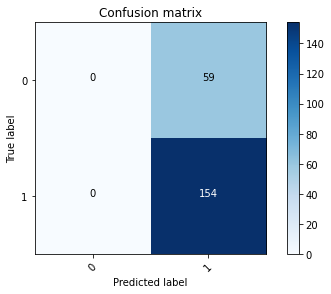

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


plot_confusion_matrix(confusion_matrix(y_test,y_pred), range(2))

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py

In [21]:
def plotROC_classifier(clf, X_tmp, y_tmp, X_tmp_test, y_tmp_test): #cv):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    viz = RocCurveDisplay.from_estimator(
            clf,
            X_tmp_test,
            y_tmp_test,
            name="ROC fold {}".format(0),#i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="Receiver operating characteristic example",
    )
    ax.legend(loc="lower right")
    plt.show()

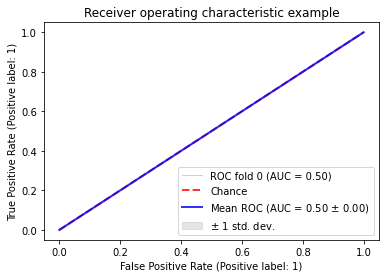

In [22]:
plotROC_classifier(svclassifier, X, y, X_test, y_test)

# Memebership inference

based on code from Simon (https://github.com/jim-smith/GRAIMatter/blob/main/WP1/notebooks/membership_inference_example.ipynb)

### Construct a dataset with label of whether or not in the training

Construct a dataset with label of whether or not in the training. Assumption is that attacker has access to dataset of training and testing examples. Obviously this is an unrealistic attack model but serves to identify whether the model is intrinsically weak.

In [44]:
def classification_labels(clf, sort_probs=False, keep_top=-1):
    miX = np.concatenate(
        (
            clf.predict_proba(X_train),
            clf.predict_proba(X_test)
        )
    )
    
    # Some methods sort the probs so that the highest
    # is always feature 1
    if sort_probs:
        miX = -np.sort(-miX, axis=1)

    if keep_top > -1:
        miX = miX[:, :keep_top]
        
    miY = np.concatenate(
        (
        np.ones((len(X_train), 1), int),
        np.zeros((len(X_test), 1), int)
        )
    ).flatten()
    return(miX,miY)

miX, miY = classification_labels(svclassifier, sort_probs=True, keep_top=1)

In [45]:
print(miX.shape)

(1064, 1)


Split the MI dataset into train and test portions

In [46]:
mi_train_x, mi_test_x, mi_train_y, mi_test_y = train_test_split(miX, miY, test_size=0.2, stratify=miY)

## Train the Attack classifier

In this case we use a random forest and a SVC

In [47]:
mi_rf = RandomForestClassifier()
mi_rf.fit(mi_train_x, mi_train_y)

RandomForestClassifier()

In [48]:
mi_svclassifier = SVC(kernel='rbf', probability=True)
mi_svclassifier.fit(mi_train_x, mi_train_y)

SVC(probability=True)

Here we plot how well the attack model can distinguish between examples that were used to train and those not used to train. A high AUC suggests that the model is _intrinsically_ disclosive.

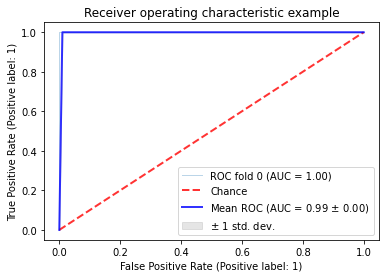

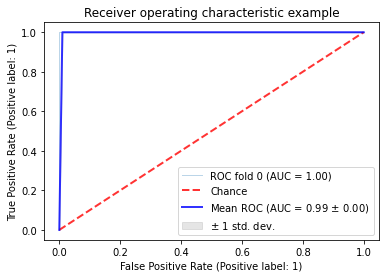

In [49]:
plotROC_classifier(mi_rf, miX, miY, mi_test_x, mi_test_y)
plotROC_classifier(mi_svclassifier, miX, miY, mi_test_x, mi_test_y)

We can visualise why the attach model is able to work by looking at the probabilities that the attack classifier gives to training and non-training examples.

In [64]:
pred_y_svc = svclassifier.predict_proba(X_test)
pred_train_y_svc = svclassifier.predict_proba(X_train)

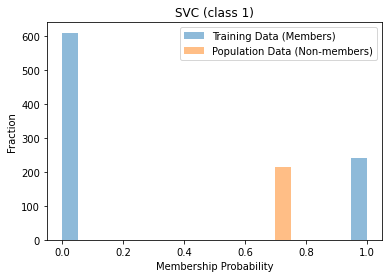

In [70]:
def plot_prob_test_train(pred_test, pred_train, plot_class=0, plt_title=None):
    fig, ax = plt.subplots()
    plt.hist(np.array(pred_train)[:, plot_class],  alpha=0.5, bins=20, label='Training Data (Members)',
                histtype='bar', range=(0, 1))
    plt.hist(np.array(pred_test)[:, plot_class],  alpha=0.5, bins=20, label='Population Data (Non-members)',
                histtype='bar', range=(0, 1))
    plt.legend()
    plt.xlabel('Membership Probability')
    plt.ylabel('Fraction')
    if plt_title:
        plt.title(f'{plt_title} (class {plot_class})')

plot_prob_test_train(pred_y_svc, pred_train_y_svc, plot_class=1, plt_title='SVC')